# Quantum Machine Learning

### Dr. Stefano Gogioso (University of Oxford)

In [1]:
%matplotlib inline
import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import networkx as nx
import math
from math import pi
from itertools import product
np.set_printoptions(floatmode="fixed", precision=3, sign="+", suppress=True)
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Some utility functions for visualization:

In [3]:
import matplotlib.tri as tri
def plt_tricontour(x, y, z, colorbar: bool = True, ticks: bool = True):
    plt.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    cntr2 = plt.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    if colorbar: plt.colorbar(cntr2)
    if not ticks:
        plt.xticks([]); plt.yticks([])
    plt.plot(x, y, 'ko', ms=3)
    
def smooth(a: np.ndarray, w: int) -> np.ndarray:
    assert w >= 3 and w%2 == 1
    pad_a = np.hstack([a[-(w//2):],a,a[:w//2]])
    return np.convolve(pad_a, np.ones(w)/w, "valid")

Imports and utility functions from (previous) notebooks:

In [4]:
from qiskit_utils import *

In [5]:
simulator = AerSimulator() # noiseless simulator
theta = Parameter("θ")
phi = Parameter("φ")
lam = Parameter("λ")

## Variational Quantum Circuits

If a family of structured circuits is "sufficiently random", by tweaking their parameters we can explore a large region in the space of quantum states. By optimising the parameter choices and suitably measuring the resulting states, we can obtain classifiers, function approximators, and regressors: in short, we can do _Quantum Machine Learning (QML)_.

This particular approach, using parametrised circuits and parameter optimisation, is known as _Variational Quantum Circuits_: this is the main way in which NISQ (Noisy Intermediate-Scale Quantum) devices are put to work today.

*Variational quantum algorithms* are algorithms using variational quantum circuits to solve a variety of tasks. Notable examples include:

- Quantum Machine Learning (QML): variational classifiers, variational function regressions and quantum neural networks
- Variational Quantum Eigensolver (VQE)
- Variational Quantum Linear Solver (VQLS) and variants for non-linear equations
- Quantum Approximate Optimisation Algorithm (QAOA)

Variational quantum algorithms comprise most of the present day applications of gate-based quantum computing. Some recent examples include:

- material discovery and optimization (Boing, IBM), catalyst design (ExxonMobil, IBM), battery chemistry (Daimler, IBM) [[1]](https://www.ibm.com/blogs/research/2020/09/quantum-industry/)
- multiflow classification problems in the energy sector (Aker BP, CQ) [[2]](https://cambridgequantum.com/aker-bp-partners-with-cambridge-quantum-computing-to-develop-quantum-machine-learning-algorithms-for-multiphase-flow/)
- cancer treatment biomarker discovery (CrownBio, JSR Life Sciences, CQ) [[3]](https://cambridgequantum.com/crownbio-and-jsr-life-sciences-partner-with-cambridge-quantum-computing-to-leverage-quantum-machine-learning-for-novel-cancer-treatment-biomarker-discovery/)
- carbon capture and storage (Total, CQ)[[4]](https://cambridgequantum.com/CQ-and-total-announce-multi-year-collaboration/)
- drug design and discovery (GSK, CQ)[[5]](https://cambridgequantum.com/cambridge-quantum-announce-ph-d-studentship-to-develop-quantum-algorithms-for-pharmaceutical-application/), (Roche, CQ)[[6]](https://cambridgequantum.com/cambridge-quantum-to-develop-quantum-algorithms-with-roche-for-drug-discovery-development/) and (Boehringer-Ingelheim, Google)[[7]](https://www.boehringer-ingelheim.com/press-release/partnering-google-quantum-computing)
- logistic optimization problems (Airbus)[[8]](https://www.airbus.com/innovation/industry-4-0/quantum-technologies/airbus-quantum-computing-challenge.html)
- computational fluid dynamics (BAE Systems, Oxford)[[9]](https://arxiv.org/abs/1907.09032)
- derivative pricing (Goldman Sachs)[[10]](https://arxiv.org/abs/2012.03819)

### Quantum Machine Learning

Quantum Machine Learning consists of the use of variational quantum circuits as classifiers and function regressors, in analogy to classical neural networks.

<div style="display: flex; flex-direction: row;">
<img src="images/qcnn.jpg" alt="" width="40%"/>
<img src="images/function_fitting_qml.jpg" alt="" width="50%"/>
</div>
(Left courtesy of <a href="https://arxiv.org/abs/1810.03787">arXiv:1810.03787</a>.
Right courtesy of <a href="https://arxiv.org/abs/2008.08605">arXiv:2008.08605</a>)

## Ansatzes

We now look at some simple ansatzes from the literature, mostly using the same numbering as in [Diagrammatic Design and Study of Ansätze for Quantum Machine Learning](https://arxiv.org/abs/2011.11073).

We create a utility function `make_params` to generate lists of indexed parameters (something which will happen a lot...).

In [6]:
from typing import Optional, List
def make_params(fst: int, snd: Optional[int] = None, label: str = "θ") -> List[Parameter]:
    start = 0 if snd is None else fst
    end = fst if snd is None else snd
    assert end >= start
    return [Parameter(f"{label}[{idx}]") for idx in range(start, end)]
make_params(2, 5)

[Parameter(θ[2]), Parameter(θ[3]), Parameter(θ[4])]

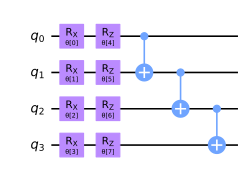

In [7]:
def ansatz2(n, params):
    num_params = ansatz2.num_params(n)
    assert len(params) == num_params, "Wrong number of parameters"
    circ = QuantumCircuit(n)
    for q in range(n): circ.rx(params[q], q)
    for q in range(n): circ.rz(params[n+q], q)
    for q in range(n-1): circ.cx(q, q+1)
    return circ
ansatz2.num_params = lambda n: 2*n
ansatz2(4, make_params(8)).draw("mpl", scale=0.8)

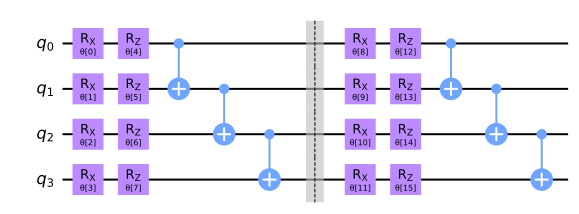

In [8]:
circ = QuantumCircuit(4)
params = make_params(16)
circ.compose(ansatz2(4, params[:8]), inplace=True)
circ.barrier()
circ.compose(ansatz2(4, params[8:]), inplace=True)
circ.draw("mpl")

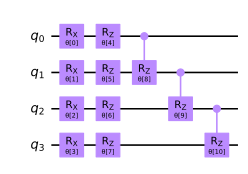

In [9]:
def ansatz3(n, params):
    num_params = ansatz3.num_params(n)
    assert len(params) == num_params, "Wrong number of parameters"
    circ = QuantumCircuit(n)
    for q in range(n): circ.rx(params[q], q)
    for q in range(n): circ.rz(params[n+q], q)
    for q in range(n-1): circ.crz(params[2*n+q], q, q+1)
    return circ
ansatz3.num_params = lambda n: 3*n
ansatz3(4, make_params(12)).draw("mpl", scale=0.8)

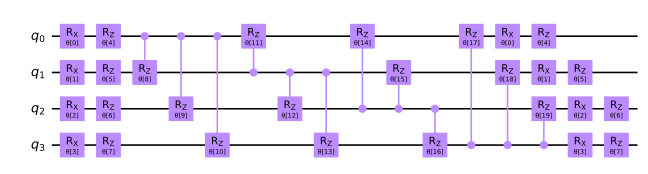

In [10]:
def ansatz5(n, params):
    num_params = ansatz5.num_params(n)
    assert len(params) == num_params, "Wrong number of parameters"
    circ = QuantumCircuit(n)
    for q in range(n): circ.rx(params[q], q)
    for q in range(n): circ.rz(params[n+q], q)
    j = 0
    for q, r in product(range(n), repeat=2):
        if r != q:
            circ.crz(params[2*n+j], q, r)
            j += 1
    for q in range(n): circ.rx(params[q], q)
    for q in range(n): circ.rz(params[n+q], q)
    return circ
ansatz5.num_params = lambda n: n*(n+3)
ansatz5(4, make_params(28)).draw("mpl", scale=0.8)

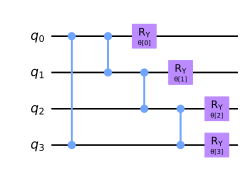

In [11]:
def ansatz10(n, params):
    num_params = ansatz10.num_params(n)
    assert len(params) == num_params, "Wrong number of parameters"
    circ = QuantumCircuit(n)
    circ.cz(0, n-1)
    for q in range(n-1): circ.cz(q, q+1)
    for q in range(n): circ.ry(params[q], q)
    return circ
ansatz10.num_params = lambda n: n
ansatz10(4, make_params(4)).draw("mpl", scale=0.8)

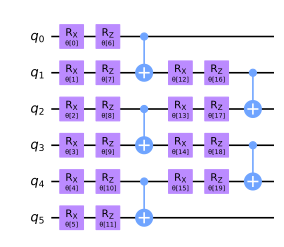

In [12]:
def ansatz11(n, params):
    num_params = ansatz11.num_params(n)
    assert len(params) == num_params, "Wrong number of parameters"
    circ = QuantumCircuit(n)
    for q in range(n): circ.rx(params[q], q)
    for q in range(n): circ.rz(params[n+q], q)
    for q in range(n//2): circ.cx(2*q, 2*q+1)
    for q in range(1, n-1): circ.rx(params[2*n+q-1], q)
    for q in range(1, n-1): circ.rz(params[3*n+q-3], q)
    for q in range(0, (n-1)//2): circ.cx(2*q+1, 2*q+2)
    return circ
ansatz11.num_params = lambda n: 4*n-4
ansatz11(6, make_params(20)).draw("mpl", scale=0.8)

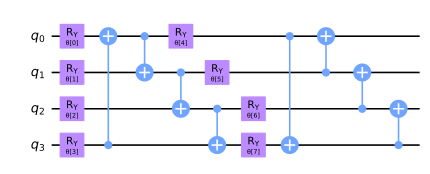

In [13]:
def ansatz15(n, params):
    num_params = ansatz15.num_params(n)
    assert len(params) == num_params, "Wrong number of parameters"
    circ = QuantumCircuit(n)
    for q in range(n): circ.ry(params[q], q)
    circ.cx(n-1, 0)
    for q in range(n-1): circ.cx(q, q+1)
    for q in range(n): circ.ry(params[n+q], q)
    circ.cx(0, n-1)
    for q in range(n-1): circ.cx(q+1, q)
    return circ
ansatz15.num_params = lambda n: 2*n
ansatz15(4, make_params(8)).draw("mpl", scale=0.8)

## Data Encoding

The parameters of the ansatz are optimised over to explore the space of states. However, we still have to encode our problem data into our quantum state (and decode our desired solution from the state). There are several strategies for data encoding.

For discrete data, a common approach is to encode the data into bitstrings (in a structured way), which are then encoded into the computational basis. This is the case for a number of tasks:

- in ML classifiers, problem data is encoded into computational basis states, which are then used as inputs to the circuit.
- in sampling algorithms (such as Simon's algorithm, Quantum Annealing or QAOA), candidate problem solutions are encoded into bitstrings, which are made to appear with amplified probability in measurements.

In some cases, combinatorial data is encoded directly into the structure of the ansatz itself. This is, for example, what happens with QAOA.

For continuous data, there are two common encoding approaches: rotation encoding and amplitude encoding.

- In _rotation encoding_, continuous data is mapped onto the parameter space for parametric rotations, typically single-qubit X, Y or Z rotations.
- In _amplitude encoding_, continuous data is mapped onto the (absolute value of) the statevector coefficients.

The extraction of amplitude-encoded data is done via measurement: the parameters are the probabilities of different measurement outcomes. Rotation-encoded data is typically extracted by taking the expectation value of single-qubit (or few-qubit) Pauli observables. Regardless of encoded data, expectation values are a standard way to extract linear data from quantum circuits (e.g. for use in regressions).

## Rotation encoding

For continuous data, a common encoding strategy sees the data normalised and mapped onto the parameter space for parametric rotations, typically single-qubit X, Y or Z rotations: 
- Linear data is normalised and mapped onto a suitably restricted range of angles, such as $[-\pi/2, \pi/2]$ or $[0, \pi]$.
- Circular data (e.g. directions in 2D) can be mapped directly onto the full rotation angle range $[0, 2\pi)$.

Vector data (e.g. 2D planar and 3D spatial data) is typicallly handled by considering each dimension independently.

As our simplest example, we encode some linear data in the range $[0, \pi]$ using a single X (or Y) rotation and attempt to decode it using a $\text{Z}$ measurment (and taking the expectation value):

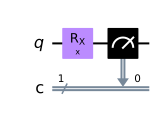

In [14]:
x_param = Parameter("x")
circ = QuantumCircuit(1, 1)
circ.rx(x_param, 0)
circ.measure(0, 0)
circ.draw("mpl")

Taking the raw expectation value doesn't quite work out...

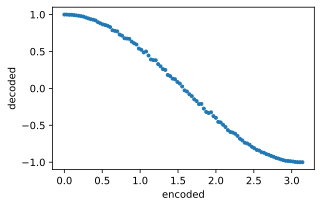

In [13]:
x_vals = np.linspace(0, pi, 100)
batch = [circ.assign_parameters({x_param: x_val}) for x_val in x_vals]
counts_list = execute(batch, simulator, shots=5000).result().get_counts()
x_vals_decoded = [expval(counts) for counts in counts_list]
# Plot the decoded values
plt.figure(figsize=(pi*1.5, 3)); plt.xlabel("encoded"); plt.ylabel("decoded")
plt.plot(x_vals, x_vals_decoded, "."); plt.show()

...but this is only because the expectation value for the Z observable is $\cos(x)$:

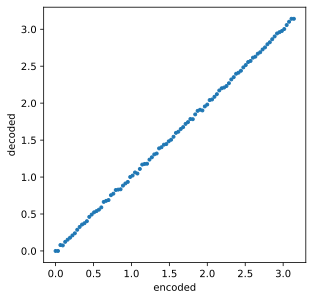

In [14]:
x_vals_decoded = [math.acos(expval(counts)) for counts in counts_list]
# Plot the decoded values
plt.figure(figsize=(pi*1.5, pi*1.5)); plt.xlabel("encoded"); plt.ylabel("decoded")
plt.plot(x_vals, x_vals_decoded, "."); plt.show()

For more complicated models, the (co-)sinusoidal behaviour of expectation values is actually an expressive feature. A recent work [arXiv:2008.08605](https://arxiv.org/abs/2008.08605) on variational quantum circuits for quantum machine learning shows that rotation encoding strategies amount to function regression by truncated Fourier series: 
$$
x \mapsto \sum_{n=-k}^{k} c_{|n|} e^{2i n x}
$$
Truncated Fourier series can fit a large class of interesting functions, so this observation sheds some light on the computational power of quantum machine learning.

The work considers generic rotation encoding scenarios, where parameters (e.g. $x$ below) are encoded into the rotations of certain circuit blocks, separated by other trainable circuit blocks (ansatz layers). The overall number of encoding rotations (in the data encoding blocks $S(x)$) determines the frequencies $w_1,...,w_r$ in the Fourier series approximation, while the trainable blocks $W^{(i)}$ determine the coefficients $c_i$ of the series.

<img src="images/quantum_models_fourier.jpg" alt="" width="60%"/>
<br>
Courtesy of <a href="https://arxiv.org/abs/2008.08605">arXiv:2008.08605</a>

The authors show that increasing the number of qubits and rotations encoding the input results in approximations of the target function by turncated Fourier series of increasing degree (and hence accuracy). The function regressions shown below are obtained after 200 steps of optimisation using the Adam optimizer. 

<img src="images/function_fitting_qml.jpg" alt="" width="60%"/>
<br>
Courtesy of <a href="https://arxiv.org/abs/2008.08605">arXiv:2008.08605</a>

We implement the linear circuit used in the paper to display the effects of rotation encoding with parameter repetition. The `r` parameter specifies the number of repetitions of the encoding rotation.

len(params) = 13


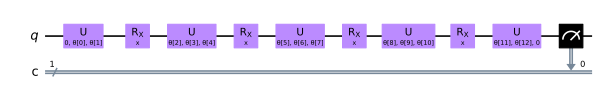

In [16]:
cache = {}
def fitting_circ(r: int):
    if r in cache: return cache[r]
    circ = QuantumCircuit(1, 1)
    params = make_params(3*r+1)
    ext_params = [0]+params+[0]
    x = Parameter("x")
    for l in range(r+1):
        if l > 0: circ.rx(x, 0)
        circ.u(*ext_params[l*3:l*3+3], 0)
    circ.measure(0, 0)
    cache[r] = (circ, params, x)
    return circ, params, x
circ, params, x = fitting_circ(4)
print(f"{len(params) = }")
circ.draw("mpl", scale=0.8, fold=30)

We also define a function that computes the function associated to given trainable parameters.

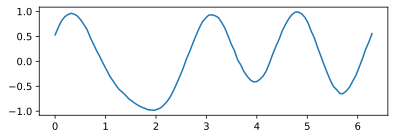

In [17]:
def fitting_fun(x_vals, param_vals, backend=simulator, **kwargs):
    nparams = len(param_vals)
    assert nparams % 3 == 1 and nparams > 0
    r = (nparams-1)//3
    circ, params, x_param = fitting_circ(r)
    bound_circ = circ.assign_parameters(dict(zip(params, param_vals)))
    batch = [bound_circ.assign_parameters({x_param: x_val}) for x_val in x_vals]
    counts_list = execute(batch, backend, **kwargs).result().get_counts()
    expvals = np.array([expval(counts) for counts in counts_list])
    return expvals
plt.figure(figsize=(2*pi, 2))
x_vals = np.linspace(0, 2*pi, 100)
rng = np.random.default_rng(seed=0)
param_vals = rng.uniform(-pi/4, pi/4, size=3*4+1)
plt.plot(x_vals, fitting_fun(x_vals, param_vals, shots=5000)); plt.show()

We plot a sample of random response functions for the circuit. Later on, we'll use this circuit to perform some basic function-fitting.

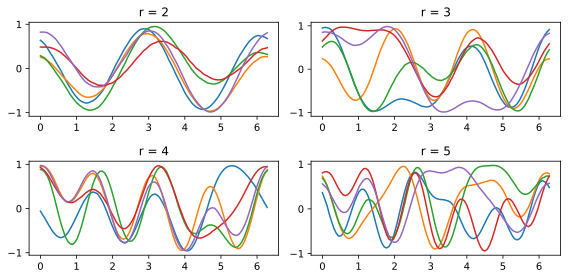

Wall time: 20.1 s


In [72]:
rng = np.random.default_rng(seed=1)
plt.figure(figsize=(8, 4))
for i, r in enumerate(range(2, 6)):
    plt.subplot(221+i); plt.title(f"{r = }")
    for _ in range(5):
        param_vals = rng.uniform(-pi/3, pi/3, size=3*r+1)
        y_vals = fitting_fun(x_vals, param_vals, shots=2000)
        plt.plot(x_vals, smooth(y_vals, 5))
plt.tight_layout(h_pad=1.2); plt.show()

## Optimisation

The entire point of Machine Learning is to *learn* values for the parameters of an ansatz that are (near-)optimal for a given problem. In classical machine learning, this is typically done by some form of *gradient descent*: at each iteration, the parameters are adjusted in a direction which reduces the loss.

In quantum machine learning, all evaluations must be performed on a quantum processor: if we want to estimate gradients, we must provide quantum circuits to do so.

Exact gradient estimation for variational quantum circuits is possible, but requires the execution of specialised circuits, usually twice as many as the number of parameters. This is a big problem: execution of circuits is expensive in terms of time and resources: the execution of hundreds or thousands of circuits for each gradient descent iteration is often an unacceptable cost. 

Furthermore, many traditional gradient descent techniques are not robust to noise: the estimated gradient coming from a (near-term) quantum processor will inevitably be random, possibly breaking any convergence guarantees.

Finally, the effect of noise is to flatten out the finer details of the loss landscape: the closer one gets to the noise threshold, the harder it is to further improve near-optimal solutions.

<div align="center">
<img src="images/noisy-opt.svg" alt="Noisy Optimisation" width="100%"/>
</div>

A good solution to gradient estimation in noisy scenarios is  [SPSA](https://www.jhuapl.edu/SPSA/PDF-SPSA/Spall_An_Overview.PDF) (Simultaneous Perturbation Stochastic Approximation): a noise-resistant algorithm that stochastically estimates the gradient of a function using a single random shift $c\underline{\Delta}$, where $\Delta_i = \pm 1$ with 50%-50% probability independently for each parameter $\theta_i$.

The gradient $g := \nabla f$ for the objective function $f$ is then approximated as follows, where $c$ is a step parameter that depends on the iteration (more later):

$$
g \left(\underline{\theta}\right)_i
\approx
\frac{f\left(\underline{\theta} + c\underline{\Delta}\right)-f\left(\underline{\theta}-c\underline{\Delta}\right)}{2c\Delta_i}
$$

Taking the average of a list of gradient samples yields a value which converges to the true gradient as the number of samples is increased. A 2nd order variant of SPSA exists which also estimates the Hessian, with a constant number of function evaluations.

An implementation of the [SPSA optimizer](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) can be found in [`qiskit.algorithms.optimizers`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html), together with party favourites such as [COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html), [ADAM](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.ADAM.html) (often used by [PennyLane](https://pennylane.ai/) demos) and [Conjugate Gradient Descent](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.CG.html).

In [18]:
from qiskit.algorithms.optimizers import SPSA, COBYLA, ADAM, CG

The COBYLA (Constrained Optimization By Linear Approximation) optimizer is popular choice for noisy optimization in the context of variational quantum circuits(cf. [M.J.D. Powell 1994](https://link.springer.com/chapter/10.1007/978-94-015-8330-5_4) and the [scipy implementation](https://github.com/scipy/scipy/blob/v1.5.4/scipy/optimize/cobyla.py)). It requires a single circuit evaluation per iteration, which makes it great for non-parallelised simulation and non-batched QPU execution.

COBYLA is a gradient-less "trust region" method. For optimization over $k$ variables, the algorithm maintains a simplex $v_1,...,v_{k+1}$ in $k$-dimensional space together with an approximate solution $x$ (inside it) and a progressively decreasing radius $\rho$. The simplex determines a local linear approximation of the function: the update step is performed by solving a linear program based on this data, with the constraint that the next approximate solution fall within radius $\rho$ of the current one.

Optimizers in Qiskit expect objective functions taking a single array of parameters as their only argument, of fixed length `num_vars`:

```py
def obj_fun(params):
    ...
```

The `optimize` method can then be used to minimize the objective function, starting from initial parameter values specified by the `initial_point` keyword argument (which is not actually optional):

```py
Optimizer.optimize(num_vars, objective_function,
                   gradient_function=None,
                   variable_bounds=None,
                   initial_point=None)
```

The `optimize` method returns a triple `(point, value, nfev)` of the optimal `point` in parameter space, the corresponding objective function `value`, and the number `nfev` of calls made to the objective function.

Each optimizer has individual initialisation parameters. For COBYLA, this can be as simple as the maximum number of iterations. Below is a very simple example with a quadratic cost function on 3 parameters.

In [19]:
cobyla_optimizer = COBYLA(maxiter=500)

def obj_fun(x):
    target = np.array([1,2,3])
    return np.linalg.norm(x-target)-5

init_params = np.array([-30, 10, 20])
point, value, nfev = cobyla_optimizer.optimize(3, obj_fun, initial_point=init_params)
print(f"Optimal params: {point}")
print(f"Optimal obj function value: {value:.3f}")
print(f"Number of obj function calls: {nfev}")

Optimal params: [+1.000 +2.000 +3.000]
Optimal obj function value: -5.000
Number of obj function calls: 97


## 1D Function Approximation

As our simples example of quantum machine learning, we look at 1D function approximation and we reproduce some of the results of <a href="https://arxiv.org/abs/2008.08605">arXiv:2008.08605</a>. Below is the target function $f$ which we will attempt to approximate.

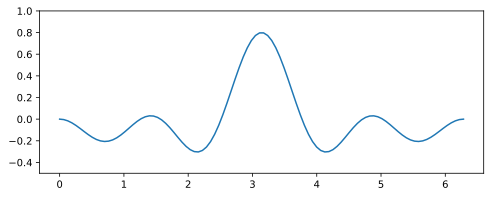

In [20]:
def f(x):
    return sum(0.1*(1-1j)*np.exp(1j*n*(x+pi))
               for n in range(-4, 5) if n != 0).real
x_vals = np.linspace(0, 2*pi, 100) # 100 linearly spaces values from 0 to 2pi 
y_vals = f(x_vals)
plt.figure(figsize=(8, 3)); plt.ylim(-0.5, 1)
plt.plot(x_vals, y_vals)
plt.show()

Our objective function will train the circuit parameter by evaluating the target function at 30 linearly spaced points in $[0, 2\pi]$.

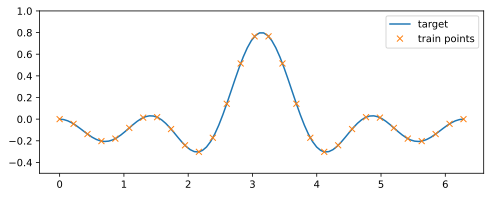

In [21]:
x_vals_train = np.linspace(0, 2*pi, 30)
y_vals_train = f(x_vals_train)
plt.figure(figsize=(8, 3)); plt.ylim(-0.5, 1)
plt.plot(x_vals, y_vals, label="target")
plt.plot(x_vals_train, y_vals_train, "x", label="train points")
plt.legend(); plt.show()

We create a function which returns our objective function together with a few lists used to keep track of objective value, parameter values and function output values across all iterations.

In [22]:
def make_obj_fun(x_vals, y_vals, backend=simulator, **kwargs):
    hist = {"error": [], "param_vals": [], "y_val": []}
    def obj_fun(param_vals):
        circ_y_vals = fitting_fun(x_vals, param_vals, backend, **kwargs)
        rmse = (sum((circ_y_vals-y_vals)**2)/len(y_vals))**0.5
        nrmse = rmse/(max(y_vals)-min(y_vals))
        hist["error"].append(nrmse)
        hist["param_vals"].append(param_vals)
        hist["y_val"].append(circ_y_vals)
        return rmse
    return obj_fun, hist

We compute an $r=3$ approximation to our target function using 150 iterations of COBYLA.

In [23]:
r=3
init_param_vals = np.zeros(3*r+1)
obj_fun, hist3 = make_obj_fun(x_vals_train, y_vals_train, shots=2000)
optimizer = COBYLA(maxiter=150) 
opt_param_vals3, _, _, = optimizer.optimize(len(init_param_vals), obj_fun, initial_point=init_param_vals)

Wall time: 37.6 s


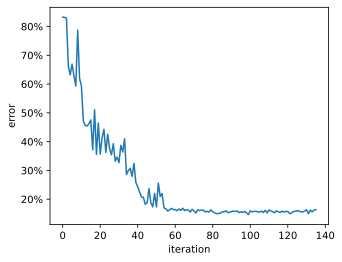

In [26]:
plt.figure(figsize=(5,4))
plt.plot(hist3["error"])
plt.xlabel("iteration"); plt.ylabel("error")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

The $r=3$ circuit is not expressive enough to fit our target function.

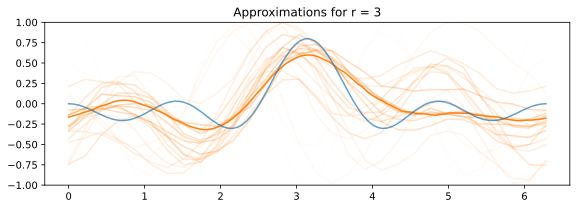

In [27]:
plt.figure(figsize=(3*pi, 3)); plt.ylim(-1, 1)
circ_y_val_hist = hist3["y_val"][0:60:3]
for i, circ_y_vals in enumerate(circ_y_val_hist):
    plt.plot(x_vals_train, circ_y_vals, "-", color="tab:orange",
             alpha = 0.3*(i+1)/len(circ_y_val_hist))
opt_y_vals = fitting_fun(x_vals, opt_param_vals3, shots=2000)
plt.plot(x_vals, smooth(opt_y_vals, 5), color="tab:orange")
plt.plot(x_vals, y_vals, alpha=0.7)
plt.title(f"Approximations for r = 3"); plt.show()

We compute an $r=4$ approximation to our target function using 150 iterations of COBYLA.

In [28]:
r=4
init_param_vals = np.zeros(3*r+1)
obj_fun, hist4 = make_obj_fun(x_vals_train, y_vals_train, shots=2000)
optimizer = COBYLA(maxiter=150) 
opt_param_vals4, _, _, = optimizer.optimize(len(init_param_vals), obj_fun, initial_point=init_param_vals)

Wall time: 45.8 s


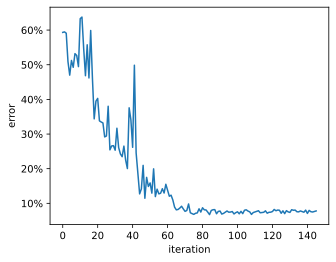

In [30]:
plt.figure(figsize=(5,4))
plt.plot(hist4["error"])
plt.xlabel("iteration"); plt.ylabel("error")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

The $r=4$ circuit is expressive enough to fit our target function.

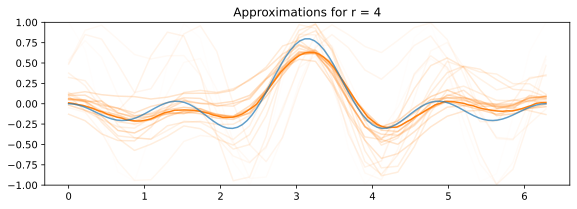

In [31]:
plt.figure(figsize=(3*pi, 3)); plt.ylim(-1, 1)
circ_y_val_hist = hist4["y_val"][0:80:4]
for i, circ_y_vals in enumerate(circ_y_val_hist):
    plt.plot(x_vals_train, circ_y_vals, "-", color="tab:orange",
             alpha = 0.3*(i+1)/len(circ_y_val_hist))
opt_y_vals = fitting_fun(x_vals, opt_param_vals4, shots=2000)
plt.plot(x_vals, smooth(opt_y_vals, 5), color="tab:orange")
plt.plot(x_vals, y_vals, alpha=0.7)
plt.title(f"Approximations for r = 4"); plt.show()

We also look at the evolution of parameter values across the iterations, in the case of $r=4$. Note how the parameters jump around discretely over the first 10 or so iterations: this is COBYLA building the initial simplex.

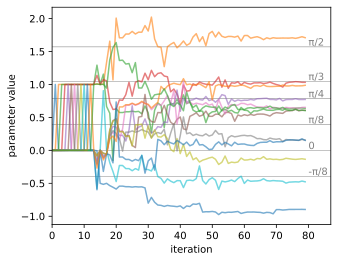

In [32]:
r = 4
plt.figure(figsize=(5,4)); plt.xlim(0, 87)
for y, t in zip([pi/2, pi/3, pi/4, pi/8, 0, -pi/8],
                ["π/2", "π/3", "π/4", "π/8", "0", "-π/8"]):
    plt.axhline(y=y, color="gray", ls="-", lw=0.5)
    plt.text(80, y+0.02, t, color="gray")
for i in range(3*r+1):
    param_i_hist = [param_vals[i] for param_vals in hist4["param_vals"]][:80]
    plt.plot(param_i_hist, alpha=0.6)
plt.xlabel("iteration"); plt.ylabel("parameter value")
plt.show()

## 2D Function Approximation

We modify our ansatz to encode 2D $(x,y)$ coordinates using $\text{X}$ rotations on 2 qubits, with trainable entangling blocks.

In [40]:
cache2 = {}
def fitting_circ2(r: int):
    if r in cache2: return cache2[r]
    circ = QuantumCircuit(2, 1)
    params = make_params(7*r+4)
    ext_params = [0,0]+params[:-1]+[0, params[-1]]
    x = Parameter("x"); y = Parameter("y")
    for l in range(r+1):
        if l > 0:
            circ.rx(x, 0)
            circ.rx(y, 1)
        circ.u(*ext_params[l*7:l*7+6:2], 0)
        circ.u(*ext_params[l*7+1:l*7+7:2], 1)
        circ.compose(z_phase_gadget(2, ext_params[l*7+6]), inplace=True)
        circ.barrier()
    circ.cx(1, 0)
    circ.measure(0, 0)
    cache2[r] = (circ, params, (x,y))
    return circ, params, (x,y)

len(params) = 25


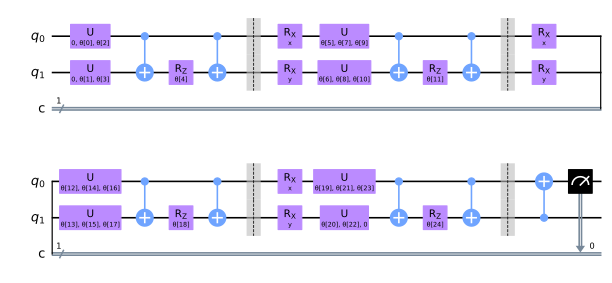

In [44]:
circ, params, (x,y) = fitting_circ2(3)
print(f"{len(params) = }")
circ.draw("mpl", scale=0.8, fold=15)

We also update the corresponding function, which now takes 2D inputs.

In [42]:
def fitting_fun2(x_vals, y_vals, param_vals, backend=simulator, **kwargs):
    nparams = len(param_vals)
    assert nparams % 7 == 4 and nparams > 0
    r = (nparams-4)//7
    circ, params, (x_param, y_param) = fitting_circ2(r)
    bound_circ = circ.assign_parameters(dict(zip(params, param_vals)))
    batch = [bound_circ.assign_parameters({x_param: x_val, y_param: y_val})
             for x_val, y_val in zip(x_vals, y_vals)]
    counts_list = execute(batch, backend, **kwargs).result().get_counts()
    expvals = np.array([expval(counts) for counts in counts_list])
    return expvals

Below are some random response functions for our circuit:

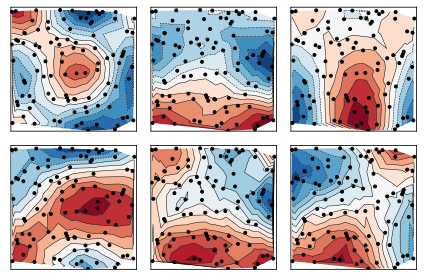

Wall time: 28.5 s


In [46]:
r = 3
rng = np.random.default_rng(seed=2)
x_vals = rng.uniform(-1, 1, size=100)
y_vals = rng.uniform(-1, 1, size=100)
plt.figure(figsize=(6,4))
for i in range(6):
    plt.subplot(231+i)
    param_vals = rng.uniform(-pi/3, pi/3, size=7*r+4)
    z_vals = fitting_fun2(x_vals, y_vals, param_vals)
    plt_tricontour(x_vals, y_vals, z_vals, ticks=False, colorbar=False)
    plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.tight_layout(); plt.show()

As our target function, we choose a saddle:

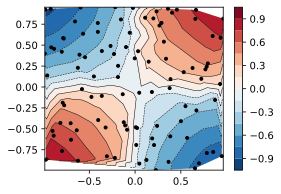

In [47]:
def g(x, y):
    return np.sign(x*y)*abs(x*y)**0.5
plt.figure(figsize=(4,3))
z_vals = g(x_vals, y_vals)
plt_tricontour(x_vals, y_vals, z_vals)
plt.show()

In [48]:
def make_obj_fun2(x_vals, y_vals, z_vals, backend=simulator, **kwargs):
    hist = {"error": [], "param_vals": [], "z_val": []}
    def obj_fun(param_vals):
        circ_z_vals = fitting_fun2(x_vals, y_vals, param_vals, backend, **kwargs)
        rmse = (sum((circ_z_vals-z_vals)**2)/len(z_vals))**0.5
        nrmse = rmse/(max(z_vals)-min(z_vals))
        hist["error"].append(nrmse)
        hist["param_vals"].append(param_vals)
        hist["z_val"].append(circ_z_vals)
        return rmse
    return obj_fun, hist

We compute an $r=3$ approximation to our target function using 200 iterations of COBYLA.

In [49]:
r = 3
init_param_vals = np.zeros(7*r+4)
obj_fun, hist2d = make_obj_fun2(x_vals, y_vals, z_vals, shots=1000)
optimizer = COBYLA(maxiter=200) 
opt_param_vals2d, _, _, = optimizer.optimize(len(init_param_vals), obj_fun, initial_point=init_param_vals)

Wall time: 11min 1s


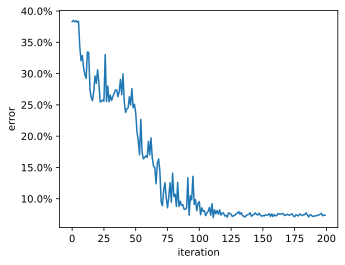

In [50]:
plt.figure(figsize=(5,4))
plt.plot(hist2d["error"])
plt.xlabel("iteration"); plt.ylabel("error")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

The $r=3$ circuit is expressive enough to fit our target function.

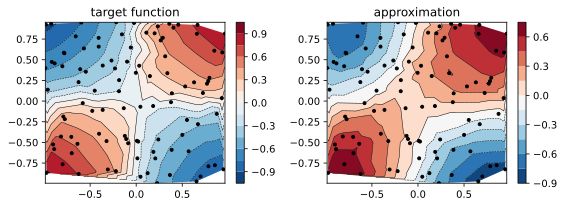

In [51]:
plt.figure(figsize=(8, 3))
opt_z_vals = hist2d["z_val"][-1]
plt.subplot(121); plt.title("target function")
plt_tricontour(x_vals, y_vals, z_vals)
plt.subplot(122); plt.title("approximation")
plt_tricontour(x_vals, y_vals, opt_z_vals)
plt.tight_layout(); plt.show()

## The Parameter-shift rule

For a generic differentiable function $f(\underline{\theta})$, estimating the gradient requires a limit:

$$
\frac{\partial f}{\partial \theta_j}
=
\lim_{\delta \rightarrow 0}
\frac{
f(\underline{\theta}+\delta \underline{e}^{(j)})
-f(\underline{\theta}-\delta \underline{e}^{(j)})
}{\delta}
$$

where $\underline{e}^{(j)}$ is the standard basis vector which is $1$ at coordinate $j$ and $0$ everywhere else. When $f$ is structured, e.g. constructed from elementary functions by composition and arithmetic operations, then the process of computing derivatives can be automated. This is, for example, what PyTorch's [Autograd library](https://pytorch.org/docs/stable/autograd.html) does for classical machine learning. Even with automatic differentiation, however, computation of the gradient $\nabla f$ requires the evaluation of functions different from $f$.

Things are different for quantum circuit. They involve trigonometric functions, and trigonometric functions are special: they provide their own derivatives. Consider $\sin(\theta)$, for example:

$$
\begin{align*}
\frac{d\sin}{d\theta}
&=
\cos(\theta)
=
\frac{\sin(\theta + \pi/2) - \sin(\theta - \pi/2)}{2}
\\
\frac{d\cos}{d\theta}
&=
-\sin(\theta)
=
\frac{\cos(\theta + \pi/2) - \cos(\theta - \pi/2)}{2}
\end{align*}
$$

Many 1-parameter quantum gates take the form $U(\theta) = \exp(-i\theta M)$ for some generating self-adjoint matrix $M$. Examples include the single-qubit rotations:

$$
\begin{align*}
\text{RX}(\theta) &= \exp(-i\theta/2 \text{X})\\
\text{RY}(\theta) &= \exp(-i\theta/2 \text{Y})\\
\text{RZ}(\theta) &= \exp(-i\theta/2 \text{Z})\\
\end{align*}
$$

For such gates, we have the following decomposition, drawing a connection to the trigonometric functions from before:

$$
U(\theta)
=
\exp(-i\theta M)
=
\cos(r\theta)\text{I} -\frac{i\sin(r\theta)}{r} M
$$

The *parameter* shift rule concerns loss functions taking a specific form:

$$
f(\underline{\theta})
=
\langle \psi | U(\underline{\theta})^\dagger
H
U(\underline{\theta}) | \psi\rangle
$$

where $H$ is some self-adjoint matrix and $U(\underline{\theta})$ is a circuit/unitary. The simples example includes the probability of a computational basis measurement outcome:

$$
\langle \psi | U(\underline{\theta})^\dagger
|\underline{b}\rangle \langle \underline{b}|
U(\underline{\theta}) | \psi\rangle
=
|\langle \underline{b}| U(\underline{\theta}) | \psi\rangle|^2
=
\mathbb{P}(\underline{b})
$$


Consider one such function $f(\underline{\theta})$, for a circuit $U(\underline{\theta})$ in which each parameter $\theta_j$ appears once, as part of some parametric gate $U(\theta_j) = \exp(-i\theta_j M_j)$.
The following result is known as the *parameter-shift rule*, where $r_j$ and $s_j$ are numbers which can be computed from the gate generatror $M_j$ (known as the *recipe*):

$$
\frac{\partial f}{\partial \theta_j}
=
r_j\big(
f(\underline{\theta} + s_j \, \underline{e}^{(j)})
- f(\underline{\theta} - s_j \, \underline{e}^{(j)})
\big)
$$

For single qubit rotations, $r = 1/2$ and $s = \pi/2$. For a detailed description of the parameter-shift rule see [Evaluating analytic gradients on quantum hardware](https://arxiv.org/abs/1811.11184).

The parameter-shift rule gives the following algorithm to evaluate the gradient of a circuit $U(\underline{\theta})$, knowing the recipe $(r_j, s_j)$ for each parameter $\theta_j$:

1. for each $j$, evaluate $f(\underline{\theta} + s \, \underline{e}^{(j)})$ and $f(\underline{\theta} - s \, \underline{e}^{(j)})$, by executing the circuit $U$ with a shift in parameter $\theta_j$
2. compute the gradient as

$$
\nabla f(\underline{\theta})
=
\Big(r_j\big(
f(\underline{\theta} + s_j \, \underline{e}^{(j)})
- f(\underline{\theta} - s_j \, \underline{e}^{(j)})\big)\Big)_{j=1...m}
$$

3. update the parameter by following some exact gradient descent technique, e.g. vanilla gradient descent:

$$
\underline{\theta}_{t+1} = \underline{\theta}_{t} - \eta_t \nabla f(\underline{\theta}_t) 
$$

Several advanced gradient descent techniques have been adapted to variational quantum circuits, including natural gradient descent and stochastic gradient descent. We refer the interested reader to [Quantum Natural Gradient
](https://arxiv.org/abs/1909.02108), [Stochastic gradient descent for hybrid quantum-classical optimization
](https://arxiv.org/abs/1910.01155) and the excellent demonstrations from [PennyLane](https://pennylane.ai/qml/demos_research.html).

Below is a simple implementation of the parameter shift rule for a given objective function, under the assumption that the parametrised gates involved are all single-qubit rotations.

In [52]:
def gradient(obj_fun, param_vals):
    m = len(param_vals)
    # generate all parameter shifts
    shifted_param_vals = []
    for j in range(m):
        ej = np.zeros(m); ej[j] = 1 # basis vector
        shifted_param_vals.append(param_vals + pi/2*ej)
        shifted_param_vals.append(param_vals - pi/2*ej)
    # evaluate all parameters shifts in parallel
    obj_fun_vals = [
        obj_fun(param_vals)
        for param_vals in shifted_param_vals
    ]
    # compute gradient
    grad = np.zeros(m)
    for j in range(m):
        grad[j] = (obj_fun_vals[2*j]-obj_fun_vals[2*j+1])/2
    return grad

To test that this works as expected, we create a small test circuit with a single parameter:

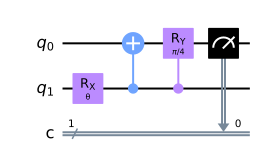

In [53]:
test_circ = QuantumCircuit(2,1)
test_circ.rx(theta, 1)
test_circ.cx(1,0)
test_circ.cry(pi/4,1,0)
test_circ.measure(0, 0)
test_circ.draw("mpl")

We create an objective function that computes the Pauli Z expectation value on qubit $q0$:

In [56]:
def obj_fun(param_vals):
    bound_circ = test_circ.bind_parameters({theta: param_vals[0]})
    counts = execute(bound_circ, simulator, shots=2000).result().get_counts()
    return expval(counts)

We plot the objective function and the computed gradient, which follows the derivative (as expected):

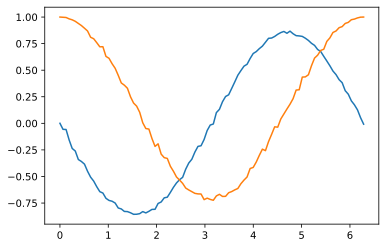

In [57]:
xs = np.linspace(0, 2*pi, 100)
ys = np.array([gradient(obj_fun, [x]) for x in xs])
zs = np.array([obj_fun([x]) for x in xs])
plt.plot(xs, ys, color="tab:blue")
plt.plot(xs, zs, color="tab:orange")
plt.show()

The parameter shift rule is too expensive to be used in current quantum machine learning applications: computing the gradient requires 2 calls to the objective function for each trainable parameter, and the quantum circuits for classifiers and regressors need to be evaluated at dozens or hundreds of samples to compute the objective value.

For the 2D regression above, for example, a batch of 100 circuits must be evaluated to compute the objective value, and 50 calls to the objective function are required to compute the gradient for its 25 trainable parameters: each iteration requires at least 5000 circuit evaluations altogether, in at least 50 separate batches (the max batch size on IBMQ systems is typically 100). At an optimistic 1-minute round-trip per batch, 200 iterations would take a week.

The parameter shift rule is extremely useful for circuit with only trainable parameters, where objective function value computation requires a limited number of circuit evaluations. This is, for example, the case for variational quantum algorithms such as VQE, VQLS and QAOA. Here we give a simple example, where we use gradient descent to find a 1-qubit state maximising a given linear combination of expectation values, specifically $\text{X}+\text{Z}$. Below is a 2-parameter circuit spanning all possible 1-qubit states.

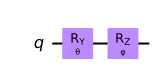

In [58]:
params = [theta, phi]
state_prep = QuantumCircuit(1)
state_prep.ry(theta, 0); state_prep.rz(phi, 0)
state_prep.draw("mpl")

We create 3 separate circuits, one for each Pauli measurement.

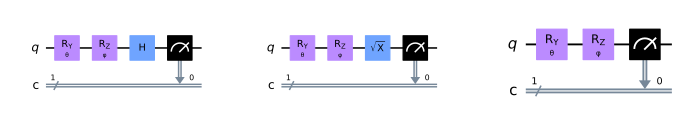

In [74]:
x_circ = QuantumCircuit(1,1)
x_circ.compose(state_prep, inplace=True)
x_circ.h(0); x_circ.measure(0,0)
y_circ = QuantumCircuit(1,1)
y_circ.compose(state_prep, inplace=True)
y_circ.sx(0); y_circ.measure(0,0)
z_circ = QuantumCircuit(1,1)
z_circ.compose(state_prep, inplace=True)
z_circ.measure(0,0)
plt.figure(figsize=(12, 6))
x_circ.draw("mpl", ax=plt.subplot(131))
y_circ.draw("mpl", ax=plt.subplot(132))
z_circ.draw("mpl", ax=plt.subplot(133))
plt.show()

For a generic linear combination of $\text{X}$, $\text{Y}$ and $\text{Z}$ expectation values, our objective function requires 3 circuit evaluations.

In [60]:
def make_obj_fun(coeffs, backend=simulator, **kwargs):
    hist = {"obj_val": [], "param_vals": []}
    def obj_fun(param_vals):
        x_counts = execute(x_circ.bind_parameters(dict(zip(params, param_vals))),
                           backend, **kwargs).result().get_counts()
        y_counts = execute(y_circ.bind_parameters(dict(zip(params, param_vals))),
                           backend, **kwargs).result().get_counts()
        z_counts = execute(z_circ.bind_parameters(dict(zip(params, param_vals))),
                           backend, **kwargs).result().get_counts()
        obj_val = coeffs@np.array([expval(x_counts),expval(y_counts),expval(z_counts)])
        hist["obj_val"].append(obj_val)
        hist["param_vals"].append(param_vals)
        return obj_val
    return obj_fun, hist

Because gradients are involved, we also need to create a gradient function, which will be passed to the optimiser.

In [61]:
def make_grad_fun(obj_fun, store_obj_val: bool = True):
    hist = {"grad": [], "param_vals": []}
    if store_obj_val:
        hist["obj_val"] = []
    def grad_fun(param_vals):
        grad = gradient(obj_fun, param_vals)
        hist["grad"].append(grad)
        hist["param_vals"].append(param_vals)
        if store_obj_val:
            obj_val = obj_fun(param_vals)
            hist["obj_val"].append(obj_val)
        return grad
    return grad_fun, hist

We run 25 iterations with the ADAM optimizer, at a learning rate `lr=0.1`. We plot the objective value: since we chose $\frac{1}{\sqrt{2}}\left(\text{X}+\text{Z}\right)$ as our linear combination of expectation values, the minimum objective value that can be achieved is -1. Indeed, the parameters quickly converge to this value.

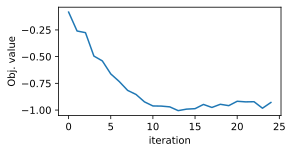

Wall time: 3.87 s


In [62]:
obj_fun, _ = make_obj_fun(-np.array([1, 0, 1])/np.sqrt(2), shots=1000)
grad_fun, hist = make_grad_fun(obj_fun)
optimizer = ADAM(maxiter=25, lr=0.1)
optimizer.optimize(2, obj_fun, gradient_function=grad_fun, initial_point=[2*pi/3, pi/4])
plt.figure(figsize=(4,2)); plt.plot(hist["obj_val"])
plt.xlabel("iteration"); plt.ylabel("Obj. value"); plt.show()

Below we visualize the migration of the quantum state on the Bloch sphere from the initial state (spherical coordinates $(\theta,\varphi) = (\frac{2\pi}{3}, \frac{\pi}{4})$) to the optimum state (midway between $|0\rangle$ and $|\!+\!\rangle$, at spherical coordinates $(\theta,\varphi) = (\frac{\pi}{4}, 0)$).

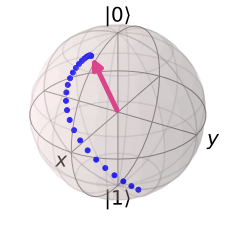

In [63]:
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.utils import _bloch_multivector_data
states = [state_prep.bind_parameters(dict(zip(params, param_vals)))
          for param_vals in hist["param_vals"]]
bloch_data = np.array([np.array(_bloch_multivector_data(state)[0])
                       for state in states])
fig = plt.figure(figsize=(3,3))
B = Bloch(fig=fig)
B.add_points([bloch_data[:,i] for i in range(3)])
B.add_vectors(bloch_data[-1])
B.render()